In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# from HelperFunctions import minibatch 
%reload_ext autoreload
%autoreload 2
from HelperFunctions import minibatch, dummify_columns, undummify, feature_standardize, label_encode_column, columns_of_type

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix

# For Bayesian Optimizer
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [2]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, AdaBoostRegressor
randomForest = RandomForestRegressor()
gbm = GradientBoostingRegressor()
abr = AdaBoostRegressor()
from xgboost import XGBRegressor
xgb = XGBRegressor()
from lightgbm import LGBMRegressor
lgb = LGBMRegressor()

# Helper Function

In [3]:
def adjust_prob(unsampled_df,sampled_df,sampled_prob): # sampled_df, sampled_prob can also be test_df, test_prob
    # turning the predicted probability into a dataframe with column name default_prob
    sample_prob_df=pd.DataFrame(sampled_prob[:,0],columns=['sampled_prob'])
    # find actual default rate for each class
    grade_rate=unsampled_df.groupby('grade')['loan_status'].apply(lambda x:(x=='Default').sum()/x.count())
    grade_rate_dict=grade_rate.to_dict()
    # mapping the unsampled_df default rates to the test_df=sampled_df
    # and then getting the array of default_rates in the test_df
    sampled_df['default_rate']=sampled_df['grade'].map(grade_rate_dict)
    sampled_df.reset_index(drop=True, inplace=True)
    sample_prob_df.reset_index(drop=True, inplace=True)
    pre_adjust_df=pd.concat([sampled_df,sample_prob_df],axis=1)
    # Adjusting the default_probability to the true probability (accounting for down/up sampling)    
    sampled_frac=0.5
    real_prob=[]
    for row in pre_adjust_df.loc[:,['default_rate','sampled_prob']].iterrows():
        beta=sampled_frac/(1-row[1]['default_rate'])
        real_prob.append(beta*row[1]['sampled_prob']/((beta-1)*row[1]['sampled_prob']+1))
        #     prob=1/(1+(1/original_fraction-1)/(1/sampled_fraction-1)*(1/sampled_prob-1))
    a=pd.DataFrame(real_prob,columns=['actual_prob'])
    b=pd.DataFrame(sampled_prob[:,0],columns=['downsampled_prob'])
    return pd.concat([a,b],axis=1)

In [4]:
df=pd.read_csv('down_sampled_df_v2.csv')
pre_df=pd.read_csv('pre_downsample_df.csv')
# df=tempdf.sample(100000)

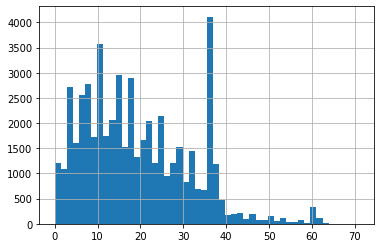

In [7]:
df.loan_duration.hist(bins=50)

In [5]:
# temp_df.issue_d=pd.to_datetime(temp_df.issue_d)

In [6]:
# df=temp_df.loc[(temp_df.issue_d>='2014-07')&(temp_df.issue_d<='2014-12'),:]

# Define Grade Weights HERE:

In [7]:
grade_weight_dict={'A':1,
                  'B':1,
                  'C':1,
                  'D':1,
                  'E':1,
                  'F':1,
                  'G':1}

df['weight']=df['grade'].map(grade_weight_dict)
grade_weight_array=df['weight'].values
index = df.index
grade_weight_frame = pd.DataFrame(grade_weight_array, index=index)

In [8]:
df=df.loc[df.loc[:,'grade']=='A',:]
df.reset_index(inplace=True,drop=True)

In [9]:
df.head()

,id,funded_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,credit_age_years,mths_since_last_delinq,mths_since_last_derog_record,derog_records,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,acc_now_delinq,collection_amt,install_util,all_util,rev_credit,inq_last_12m,chargeoff_within_12_mths,delinq_amnt,mths_since_RecentAcc_opened,all_accs_120days+_PastDue_ever,accs_90days+_PastDue_24m,accs_opened_past_12m,pct_acc_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_credit,install_credit,fico,Outstanding_mortgage_debt,revol_frac,install_frac,mort_frac,card_frac,active_card_frac,active_revol_frac,active_install_frac,open_revol_frac,good_acc_frac,loan_duration,return_rate,RANDOM,weight
0,65251140,25000.0,36,7.89,A,A5,1,MORTGAGE,94000.0,Source Verified,2015-11-01,Fully Paid,debt_consolidation,933xx,CA,19.36,0.0,18.430556,25.0,-999.0,0.0,57.1,30.0,w,0.0,-999.0,Individual,0.0,121.0,-999.0,-999.0,36500.0,-999.0,0.0,0.0,4.0,0.0,0.0,1.0,96.7,0.0,0.0,239880.0,58955.0,702.0,131064.0,0.633333,0.266667,0.100000,0.578947,0.363636,0.368421,-999.0,0.578947,0.500000,34.500000,0.040767,0.220221,1
1,62519711,14000.0,36,6.89,A,A3,3,RENT,45000.0,Not Verified,2015-10-01,Fully Paid,credit_card,288xx,NC,8.45,0.0,27.222222,-999.0,-999.0,0.0,23.5,9.0,w,0.0,-999.0,Individual,0.0,0.0,-999.0,-999.0,60900.0,-999.0,0.0,0.0,34.0,0.0,0.0,0.0,100.0,0.0,0.0,60900.0,0.0,777.0,0.0,0.777778,0.000000,0.222222,0.857143,0.500000,0.428571,-999.0,0.428571,0.333333,37.566667,0.033656,0.008344,1
2,50646937,5000.0,36,5.32,A,A1,5,MORTGAGE,80000.0,Not Verified,2015-05-01,Fully Paid,debt_consolidation,483xx,MI,10.67,0.0,7.350000,-999.0,-999.0,0.0,21.9,32.0,w,0.0,-999.0,Individual,0.0,0.0,-999.0,-999.0,72900.0,-999.0,0.0,0.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,207312.0,29912.0,727.0,98602.0,0.625000,0.343750,0.031250,0.650000,0.538462,0.450000,-999.0,0.750000,0.656250,34.500000,0.027468,0.412407,1
3,16442318,6500.0,36,7.69,A,A4,7,MORTGAGE,61000.0,Not Verified,2014-05-01,Fully Paid,debt_consolidation,985xx,WA,13.93,0.0,11.750000,68.0,-999.0,0.0,33.6,15.0,w,0.0,68.0,Individual,0.0,1101.0,-999.0,-999.0,4200.0,-999.0,0.0,0.0,13.0,4.0,0.0,0.0,73.3,0.0,0.0,217544.0,27075.0,662.0,178608.0,0.400000,0.466667,0.133333,0.500000,0.666667,0.500000,-999.0,0.666667,0.600000,36.533333,0.037775,0.562369,1
4,49924755,16000.0,36,5.32,A,A1,1,MORTGAGE,98000.0,Source Verified,2015-06-01,Fully Paid,credit_card,305xx,GA,4.69,1.0,22.488889,18.0,-999.0,0.0,27.7,42.0,w,0.0,-999.0,Individual,0.0,0.0,-999.0,-999.0,60100.0,-999.0,0.0,0.0,10.0,0.0,0.0,4.0,97.6,0.0,0.0,254900.0,0.0,747.0,179982.0,0.714286,0.142857,0.119048,0.533333,0.187500,0.166667,-999.0,0.433333,0.333333,36.533333,0.025984,0.941376,1


# Dropping features not needed for modeling

In [10]:
drop_list=['sub_grade','zip_code','RANDOM','id','loan_duration','weight','issue_d']
df.drop(drop_list,axis=1,inplace=True)

In [11]:
x_train=df.drop(['loan_status','return_rate'],axis=1)
y_train=df.loan_status

In [12]:
cat_list=columns_of_type(x_train,'string')
cont_list=columns_of_type(x_train,'number')

# Label Encode ALL Categoricals

In [13]:
label_encoded_df=label_encode_column(x_train,cat_list)

In [14]:
# label_encoded_df.describe()

# Standardize ALL Features

In [15]:
final_train_df=label_encoded_df.apply(lambda x:feature_standardize(x,scaleType='standardize'),axis=0)

# CUSTOM SCORING FUNCTION: WEIGHTED ACCURACY

In [16]:
final_train_df=label_encoded_df

In [17]:
final_train_df.describe()

,funded_amnt,term,int_rate,emp_length,annual_inc,dti,delinq_2yrs,credit_age_years,mths_since_last_delinq,mths_since_last_derog_record,derog_records,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,collection_amt,install_util,all_util,rev_credit,inq_last_12m,chargeoff_within_12_mths,delinq_amnt,mths_since_RecentAcc_opened,all_accs_120days+_PastDue_ever,accs_90days+_PastDue_24m,accs_opened_past_12m,pct_acc_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_credit,install_credit,fico,Outstanding_mortgage_debt,revol_frac,install_frac,mort_frac,card_frac,active_card_frac,active_revol_frac,active_install_frac,open_revol_frac,good_acc_frac,grade,home_ownership,verification_status,purpose,addr_state,initial_list_status,application_type
count,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.00000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.0,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000
mean,13250.168856,36.738462,7.222285,3.424765,78911.771572,16.276184,0.207505,17.761196,-570.072420,-879.510694,0.135084,38.727092,25.774109,0.008630,-805.282176,0.00075,5.600375,-645.146717,-578.655535,37818.882552,-596.896060,0.002627,0.170732,-70.559475,-78.753096,-79.049531,-77.529081,9.206604,0.080675,0.037523,173478.044653,37564.333959,724.677486,89537.227767,-78.533512,-78.810890,-59.162785,-78.544763,-78.667274,-78.744457,-610.512598,-78.550414,-65.888099,0.0,1.845403,0.760976,2.312195,21.653283,0.678799,0.022139
std,7749.062653,4.145383,0.971696,2.915551,42791.382689,9.121935,0.723960,7.988855,510.721059,337.581966,0.439838,30.300618,11.427734,0.100303,406.275277,0.02739,589.931734,502.114209,513.071843,28426.862873,490.648437,0.051193,8.813792,272.439410,269.894112,269.805221,270.255039,295.763663,0.319331,0.249810,152155.818309,37321.191180,35.803439,119241.776290,269.956332,269.874982,235.985615,269.953030,269.917143,269.894470,487.235723,269.951377,248.929721,0.0,0.929639,0.772253,1.914487,14.290656,0.467025,0.147163
min,1000.000000,36.000000,5.310000,1.000000,0.000000,0.000000,0.000000,3.213889,-999.000000,-999.000000,0.000000,-999.000000,2.000000,0.000000,-999.000000,0.00000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.000000,-999.000000,-999.000000,662.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7200.000000,36.000000,6.620000,1.000000,50000.000000,10.240000,0.000000,12.344444,-999.000000,-999.000000,0.000000,21.400000,17.000000,0.000000,-999.000000,0.00000,0.000000,-999.000000,-999.000000,18100.000000,-999.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,92.000000,0.000000,0.000000,54266.000000,9530.000000,697.000000,0.000000,0.434783,0.137931,0.000000,0.437500,0.250000,0.206897,-999.000000,0.421053,0.357143,0.0,1.000000,0.000000,1.000000,9.000000,0.000000,0.000000
50%,12000.000000,36.000000,7.350000,2.000000,70000.000000,15.670000,0.000000,16.063889,-999.000000,-999.000000,0.000000,36.800000,24.000000,0.000000,-999.000000,0.00000,0.000000,-999.000000,-999.000000,31900.000000,-999.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,100.000000,0.000000,0.000000,125623.000000,29243.000000,717.000000,0.000000,0.600000,0.263158,0.047619,0.571429,0.400000,0.333333,-999.000000,0.562500,0.466667,0.0,1.000000,1.000000,2.000000,20.000000,1.000000,0.000000
75%,18000.000000,36.000000,7.890000,5.000000,98000.00

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics.scorer import make_scorer
def grade_weighted_accuracy(y_true,y_pred,sample_weight):

    weighted_acc=accuracy_score(y_true,y_pred,
                                sample_weight=sample_weight.loc[y_true.index.values].values.reshape(-1),
                                normalize=True)
    return weighted_acc    

score_params = {"sample_weight": grade_weight_frame}

grade_weighted_scorer = make_scorer(score_func=grade_weighted_accuracy,
                                    greater_is_better=True,
                                    needs_proba=False,
                                    needs_threshold=False,
                                    **score_params)

In [19]:
grid_para_forest = {
    'n_estimators': [100],
    'max_depth':[None],
    'max_features':['auto'],
    'min_samples_leaf':[1],
    'min_samples_split':[2]
}

grid_search_forest = GridSearchCV(estimator=RandomForestClassifier(),\
                                  param_grid=grid_para_forest,\
                                  n_jobs=-1,\
                                  scoring='precision',cv=5,\
                                  return_train_score=False)

In [20]:
# %time 
grid_search_forest.fit(final_train_df,y_train)
print('best parameters:', grid_search_forest.best_params_)
print('best score:', grid_search_forest.best_score_)
# confusion_matrix(y_train, grid_search_forest.predict(final_train_df))

ValueError: pos_label=1 is not a valid label: array(['Default', 'Fully Paid'], dtype='<U10')

# Adjusting Probabilities to account for downsampling

In [ ]:
sampled_prob=grid_search_forest.predict_proba(final_train_df)
prob_df=adjust_prob(pre_df,df,sampled_prob)

In [ ]:
prob_df

In [ ]:
# prob_df.to_csv('prob_df.csv')

#### Testing without weighted accuracy

In [ ]:
# grid_search_forest = GridSearchCV(estimator=RandomForestClassifier(n_estimators=10,max_depth=2,max_features=2),\
#                                   param_grid=grid_para_forest,\
#                                   n_jobs=-1,\
#                                   cv=5,\
#                                   return_train_score=False)
# grid_search_forest.fit(final_train_df,y_train)
# print('best parameters:', grid_search_forest.best_params_)
# print('best score:', grid_search_forest.best_score_)
# confusion_matrix(y_train, grid_search_forest.predict(final_train_df))

In [ ]:
# sampled_prob=grid_search_forest.predict_proba(final_train_df)
# adjust_prob(pre_df,df,sampled_prob)